In [1]:
!pip install torch torchvision timm medmnist
!pip install numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=54680d0d55341cd9dba31254eb0974d24e5120d5677e3a77464364cfe6dc66d9
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import timm
import medmnist
from medmnist import INFO
import os
import csv

# Function to train the central model on a specified MedMNIST dataset with train-test split
def train_central_model(dataset_name, epochs=10, batch_size=32, save_dir="./results", test_split=0.2):
    # Verify the dataset name is valid
    valid_datasets = ['pathmnist', 'pneumoniamnist', 'chestmnist', 'dermamnist', 'octmnist', 'breastmnist']
    if dataset_name not in valid_datasets:
        raise ValueError(f"Dataset '{dataset_name}' is not supported. Choose from {valid_datasets}")

    # Load dataset information from MedMNIST
    info = INFO[dataset_name]
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    # Define the transformation for the dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet input size
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if n_channels == 1 else x),  # Convert 1 channel to 3 if needed
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)  # Normalize the dataset for 3 channels
    ])

    # Load the dataset
    dataset_class = getattr(medmnist, info['python_class'])
    full_train_dataset = dataset_class(split='train', transform=transform, download=True)

    # Create a train-test split
    train_size = int((1 - test_split) * len(full_train_dataset))
    test_size = len(full_train_dataset) - train_size
    train_dataset, test_dataset = random_split(full_train_dataset, [train_size, test_size])

    # Create DataLoaders for batching
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Load a pre-trained ResNet-50 model and modify the classifier layer
    model = timm.create_model('resnet50', pretrained=True)
    model.fc = nn.Linear(2048, n_classes)  # Adjust the final layer for the specific dataset

    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Directory to save results
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # File to save the training loss and test accuracy
    results_file = os.path.join(save_dir, f"{dataset_name}_training_results.csv")

    # Create CSV file and write the header
    with open(results_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Training Loss", "Test Loss", "Test Accuracy"])

    # Training loop for the base model (central model)
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)  # Move data to GPU if available

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            running_loss += loss.item() * data.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}')

        # Evaluate on test dataset
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # Turn off gradients for testing
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)  # Move data to GPU if available

                # Convert one-hot encoded labels to class indices
                labels = torch.argmax(labels, dim=1)

                outputs = model(data)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate the test loss
                test_loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

        # Save training loss and test accuracy to CSV
        with open(results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch+1, epoch_train_loss, epoch_test_loss, accuracy])

    # Final base model save
    torch.save(model.state_dict(), os.path.join(save_dir, f"{dataset_name}_final_model.pth"))

    return model.state_dict()  # Return the trained model state dict


# Function to fine-tune the model on "hospital" data
def fine_tune_hospital_model(dataset_name, model_state_dict, fine_tune_epochs=5, batch_size=32, save_dir="./results"):
    # Verify the dataset name is valid
    valid_datasets = ['pathmnist', 'pneumoniamnist', 'chestmnist', 'dermamnist', 'octmnist', 'breastmnist']
    if dataset_name not in valid_datasets:
        raise ValueError(f"Dataset '{dataset_name}' is not supported. Choose from {valid_datasets}")

    # Load dataset information from MedMNIST
    info = INFO[dataset_name]
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    # Define the transformation for the dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet input size
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if n_channels == 1 else x),  # Convert 1 channel to 3 if needed
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)  # Normalize the dataset for 3 channels
    ])

    # Load the dataset
    dataset_class = getattr(medmnist, info['python_class'])
    full_train_dataset = dataset_class(split='train', transform=transform, download=True)

    # Reserve 10% of the training data for fine-tuning as "hospital data"
    train_size = int(0.9 * len(full_train_dataset))
    hospital_data_size = len(full_train_dataset) - train_size
    _, hospital_dataset = random_split(full_train_dataset, [train_size, hospital_data_size])

    # Create DataLoader for hospital data
    hospital_loader = DataLoader(dataset=hospital_dataset, batch_size=batch_size, shuffle=True)

    # Load the pre-trained ResNet-50 model and modify the classifier layer
    model = timm.create_model('resnet50', pretrained=True)
    model.fc = nn.Linear(2048, n_classes)  # Adjust the final layer for the specific dataset

    # Load the central model's state dict
    model.load_state_dict(model_state_dict)

    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    print("Starting fine-tuning on hospital data...")

    # Fine-tuning loop
    for epoch in range(fine_tune_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for data, labels in hospital_loader:
            data, labels = data.to(device), labels.to(device)  # Move data to GPU if available

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            running_loss += loss.item() * data.size(0)

        epoch_loss = running_loss / len(hospital_loader.dataset)
        print(f'Fine-tuning Epoch [{epoch+1}/{fine_tune_epochs}], Loss: {epoch_loss:.4f}')

    # Save the fine-tuned model
    torch.save(model.state_dict(), os.path.join(save_dir, f"{dataset_name}_fine_tuned_hospital_model.pth"))
    print(f'Fine-tuned model saved as {dataset_name}_fine_tuned_hospital_model.pth')



In [5]:
model_state_dict = train_central_model('breastmnist', epochs=5, batch_size=32, save_dir="./breast_results")
fine_tune_hospital_model('breastmnist', model_state_dict, fine_tune_epochs=5, batch_size=32, save_dir="./breast_results")
#train_medmnist_model('pneumoniamnist', epochs=10, batch_size=32, save_dir="./pneumonia_results")

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Epoch [1/5], Train Loss: 0.2935
Epoch [1/5], Test Loss: 0.2596, Test Accuracy: 100.00%
Epoch [2/5], Train Loss: 0.0321
Epoch [2/5], Test Loss: 0.0683, Test Accuracy: 100.00%
Epoch [3/5], Train Loss: 0.0128
Epoch [3/5], Test Loss: 0.0221, Test Accuracy: 100.00%
Epoch [4/5], Train Loss: 0.0087
Epoch [4/5], Test Loss: 0.0092, Test Accuracy: 100.00%
Epoch [5/5], Train Loss: 0.0067
Epoch [5/5], Test Loss: 0.0084, Test Accuracy: 100.00%
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Starting fine-tuning on hospital data...
Fine-tuning Epoch [1/5], Loss: 0.0055
Fine-tuning Epoch [2/5], Loss: 0.0045
Fine-tuning Epoch [3/5], Loss: 0.0026
Fine-tuning Epoch [4/5], Loss: 0.0019
Fine-tuning Epoch [5/5], Loss: 0.0014
Fine-tuned model saved as breastmnist_fine_tuned_hospital_model.pth


## Misspecification test case

In [6]:
model_state_dict = train_central_model('pneumoniamnist', epochs=5, batch_size=32, save_dir="./pneumonia_results_ms")
fine_tune_hospital_model('breastmnist', model_state_dict, fine_tune_epochs=5, batch_size=32, save_dir="./pneumonia_results_ms")

100%|██████████| 4.17M/4.17M [00:00<00:00, 7.46MB/s]


Epoch [1/5], Train Loss: 0.0403
Epoch [1/5], Test Loss: 0.0036, Test Accuracy: 100.00%
Epoch [2/5], Train Loss: 0.0025
Epoch [2/5], Test Loss: 0.0018, Test Accuracy: 100.00%
Epoch [3/5], Train Loss: 0.0014
Epoch [3/5], Test Loss: 0.0011, Test Accuracy: 100.00%
Epoch [4/5], Train Loss: 0.0009
Epoch [4/5], Test Loss: 0.0007, Test Accuracy: 100.00%
Epoch [5/5], Train Loss: 0.0006
Epoch [5/5], Test Loss: 0.0006, Test Accuracy: 100.00%
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Starting fine-tuning on hospital data...
Fine-tuning Epoch [1/5], Loss: 0.0007
Fine-tuning Epoch [2/5], Loss: 0.0005
Fine-tuning Epoch [3/5], Loss: 0.0003
Fine-tuning Epoch [4/5], Loss: 0.0003
Fine-tuning Epoch [5/5], Loss: 0.0002
Fine-tuned model saved as breastmnist_fine_tuned_hospital_model.pth


This is an interesting result: finetuning with a larger set (pneumonia) still improves performance despite the task difference (breast vs. pneumonia).

In [7]:
def evaluate_on_original_test_set(dataset_name, model_state_dict, batch_size=32):
    """
    Evaluate the fine-tuned model on the original PneumoniaMNIST test set.

    Args:
        dataset_name (str): Name of the dataset ('pneumoniamnist').
        model_state_dict (dict): State dictionary of the fine-tuned model.
        batch_size (int): Batch size for the DataLoader.

    Returns:
        None: Prints the test accuracy and loss.
    """
    # Verify the dataset name is valid
    valid_datasets = ['pathmnist', 'pneumoniamnist', 'chestmnist', 'dermamnist', 'octmnist', 'breastmnist']
    if dataset_name not in valid_datasets:
        raise ValueError(f"Dataset '{dataset_name}' is not supported. Choose from {valid_datasets}")

    # Load dataset information from MedMNIST
    info = INFO[dataset_name]
    n_channels = info['n_channels']
    n_classes = len(info['label'])

    # Define the transformation for the dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match ResNet input size
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if n_channels == 1 else x),  # Convert 1 channel to 3 if needed
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)  # Normalize the dataset for 3 channels
    ])

    # Load the original PneumoniaMNIST test dataset
    dataset_class = getattr(medmnist, info['python_class'])
    test_dataset = dataset_class(split='test', transform=transform, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Load the pre-trained ResNet-50 model and modify the classifier layer
    model = timm.create_model('resnet50', pretrained=False)  # No need to load ImageNet weights
    model.fc = nn.Linear(2048, n_classes)  # Adjust the final layer for the specific dataset

    # Load the fine-tuned model's state dict
    model.load_state_dict(model_state_dict)

    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Evaluate on test dataset
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # Turn off gradients for testing
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)  # Move data to GPU if available

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            outputs = model(data)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the test loss
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total

    print(f"Evaluation on '{dataset_name}' Test Set:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")
evaluate_on_original_test_set(
    dataset_name='pneumoniamnist',
    model_state_dict=model_state_dict,
    batch_size=32
)


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Evaluation on 'pneumoniamnist' Test Set:
Test Loss: 0.0005
Test Accuracy: 100.00%


In [10]:
import hashlib
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
from medmnist import INFO, PneumoniaMNIST, BreastMNIST

# Utility functions
def compute_image_hash(image):
    """Compute the hash for an image."""
    return hashlib.md5(np.array(image).tobytes()).hexdigest()


def load_medmnist_dataset(dataset_name, split, resize=(224, 224), batch_size=32):
    """
    Load a MedMNIST dataset with proper preprocessing.

    Args:
        dataset_name (str): Name of the MedMNIST dataset.
        split (str): Dataset split ('train' or 'test').
        resize (tuple): Resize dimensions for the images.
        batch_size (int): Batch size for the DataLoader.

    Returns:
        DataLoader: DataLoader object for the dataset.
    """
    dataset_info = INFO[dataset_name]
    n_channels = dataset_info['n_channels']
    transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if n_channels == 1 else x),  # Convert to 3 channels if needed
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)  # Normalize for 3 channels
    ])
    dataset_class = getattr(medmnist, dataset_info['python_class'])
    dataset = dataset_class(split=split, transform=transform, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=(split == 'train'))


def load_model(num_classes, pretrained=False):
    """
    Load a ResNet-50 model with a custom classifier layer.

    Args:
        num_classes (int): Number of output classes.
        pretrained (bool): Whether to use pretrained weights.

    Returns:
        nn.Module: The ResNet-50 model.
    """
    model = timm.create_model('resnet50', pretrained=pretrained)
    model.fc = nn.Linear(2048, num_classes)
    return model


def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on a given DataLoader.

    Args:
        model (nn.Module): The model to evaluate.
        dataloader (DataLoader): The DataLoader for evaluation.
        device (torch.device): Device to perform evaluation on.

    Returns:
        tuple: Test loss and accuracy.
    """
    model.eval()
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            if labels.ndim > 1:  # Convert one-hot encoded labels to class indices
                labels = torch.argmax(labels, dim=1)

            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(dataloader.dataset)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy


# Check dataset overlap
def check_dataset_overlap(dataset1, dataset2):
    """
    Check for overlapping images between two datasets.

    Args:
        dataset1: The first dataset.
        dataset2: The second dataset.

    Returns:
        int: The number of overlapping images.
    """
    dataset1_hashes = {compute_image_hash(img.squeeze().numpy()) for img, _ in dataset1}
    dataset2_hashes = {compute_image_hash(img.squeeze().numpy()) for img, _ in dataset2}
    overlap = dataset1_hashes & dataset2_hashes
    print(f"Number of overlapping images: {len(overlap)}")
    return overlap


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load datasets
pneumoniamnist_loader = load_medmnist_dataset('pneumoniamnist', split='train')
breastmnist_loader = load_medmnist_dataset('breastmnist', split='train')

# Check overlap
pneumoniamnist_dataset = pneumoniamnist_loader.dataset
breastmnist_dataset = breastmnist_loader.dataset
overlap = check_dataset_overlap(pneumoniamnist_dataset, breastmnist_dataset)
if overlap:
    print("Overlapping images detected.")
else:
    print("No overlapping images detected.")

# Load and evaluate the model
num_classes = len(INFO['pneumoniamnist']['label'])  # Calculate number of classes
model = load_model(num_classes=num_classes, pretrained=False)
model_state_dict = torch.load('/content/pneumonia_results_ms/pneumoniamnist_final_model.pth')  # Replace with the actual model path
model.load_state_dict(model_state_dict)
model.to(device)

# Evaluate on the target dataset
breastmnist_test_loader = load_medmnist_dataset('breastmnist', split='test')
loss, accuracy = evaluate_model(model, breastmnist_test_loader, device)
print(f"Evaluation of Central Model (Trained on 'pneumoniamnist') on 'breastmnist':")
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%")




Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Number of overlapping images: 0
No overlapping images detected.


<ipython-input-10-4f5c55980370>:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load('/content/pneumonia_results_ms/pneumoniamnist_final_model.pt

Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Evaluation of Central Model (Trained on 'pneumoniamnist') on 'breastmnist':
Test Loss: 0.0185, Test Accuracy: 100.00%


Label distribution for PneumoniaMNIST: Counter({1: 3494, 0: 1214})


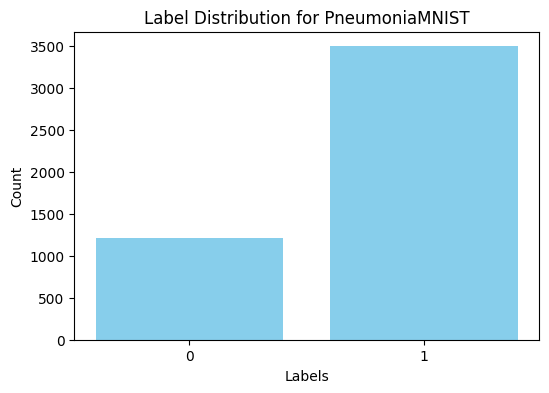

Label distribution for BreastMNIST: Counter({1: 399, 0: 147})


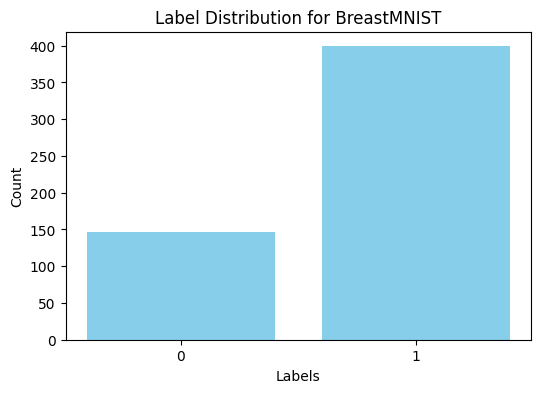

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

def check_label_balance(loader, dataset_name):
    """
    Check and visualize the label distribution for a dataset.

    Args:
        loader (DataLoader): DataLoader object for the dataset.
        dataset_name (str): Name of the dataset.

    Returns:
        None: Prints and plots the label distribution.
    """
    # Get labels from the dataset
    labels = []
    for _, label in loader.dataset:
        # Handle one-hot encoded labels
        if label.ndim > 0 and len(label) > 1:
            labels.append(torch.argmax(label).item())
        else:
            labels.append(label.item())

    # Count label occurrences
    label_count = Counter(labels)
    print(f"Label distribution for {dataset_name}: {label_count}")

    # Plot the label distribution
    plt.figure(figsize=(6, 4))
    plt.bar(label_count.keys(), label_count.values(), color='skyblue')
    plt.title(f"Label Distribution for {dataset_name}")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(list(label_count.keys()))
    plt.show()

# Call this function for PneumoniaMNIST and BreastMNIST
check_label_balance(pneumoniamnist_loader, "PneumoniaMNIST")
check_label_balance(breastmnist_loader, "BreastMNIST")

In [12]:
pip install medmnist scikit-learn

In [13]:
import numpy as np
import medmnist
from medmnist import PneumoniaMNIST
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load PneumoniaMNIST dataset
def load_pneumonia_mnist():
    data_flag = 'pneumoniamnist'
    train_dataset = PneumoniaMNIST(split='train', download=True, as_rgb=False)
    test_dataset = PneumoniaMNIST(split='test', download=True, as_rgb=False)

    # Extract images and labels
    X_train, y_train = train_dataset.imgs, train_dataset.labels
    X_test, y_test = test_dataset.imgs, test_dataset.labels

    # Flatten the images for use in Random Forests
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    return X_train, X_test, y_train.ravel(), y_test.ravel()

# Load the data
X_train, X_test, y_train, y_test = load_pneumonia_mnist()

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       234
           1       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624

Accuracy Score: 0.8493589743589743


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from medmnist import PneumoniaMNIST
from sklearn.metrics import classification_report, accuracy_score

# Load PneumoniaMNIST dataset
def load_pneumonia_mnist():
    data_flag = 'pneumoniamnist'
    train_dataset = PneumoniaMNIST(split='train', download=True, as_rgb=False)
    test_dataset = PneumoniaMNIST(split='test', download=True, as_rgb=False)

    # Extract images and labels
    X_train, y_train = train_dataset.imgs, train_dataset.labels
    X_test, y_test = test_dataset.imgs, test_dataset.labels

    # Normalize images to [0, 1] and expand dimensions for CNN
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    return X_train, X_test, y_train, y_test

# Load the data
X_train, X_test, y_train, y_test = load_pneumonia_mnist()

# Define the CNN model
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Two classes: Normal and Pneumonia
    ])
    return model

# Build and compile the model
cnn_model = build_cnn_model(input_shape=(28, 28, 1))
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predict and generate a classification report
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7296 - loss: 0.5817 - val_accuracy: 0.8238 - val_loss: 0.3639
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3024 - val_accuracy: 0.9130 - val_loss: 0.2040
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9165 - loss: 0.2135 - val_accuracy: 0.9427 - val_loss: 0.1528
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9305 - loss: 0.1799 - val_accuracy: 0.9437 - val_loss: 0.1481
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9378 - loss: 0.1656 - val_accuracy: 0.9512 - val_loss: 0.1279
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9398 - loss: 0.1619 - val_accuracy: 0.9406 - val_loss: 0.1430
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.1387 - val_accuracy: 0.9448 - val_loss: 0.1554
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9468 - loss: 0.1320 - val_accuracy: 

## Other experiments

In [16]:
fine_tune_hospital_model('pneumoniamnist', model_state_dict, fine_tune_epochs=5, batch_size=32, save_dir="./pneumonia_results_ms")

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Starting fine-tuning on hospital data...
Fine-tuning Epoch [1/5], Loss: 0.0003
Fine-tuning Epoch [2/5], Loss: 0.0000
Fine-tuning Epoch [3/5], Loss: 0.0000
Fine-tuning Epoch [4/5], Loss: 0.0000
Fine-tuning Epoch [5/5], Loss: 0.0000
Fine-tuned model saved as pneumoniamnist_fine_tuned_hospital_model.pth


In [ ]:
model_state_dict_chest = train_central_model('chestmnist', epochs=10, batch_size=32, save_dir="./chestmnist_results")

fine_tune_hospital_model('chestmnist', model_state_dict_chest, fine_tune_epochs=5, batch_size=32, save_dir="./chestmnist_results")

100%|██████████| 82.8M/82.8M [00:02<00:00, 30.4MB/s]


Epoch [1/10], Train Loss: 1.3483
Epoch [1/10], Test Loss: 1.3375, Test Accuracy: 64.01%
Epoch [2/10], Train Loss: 1.3058
Epoch [2/10], Test Loss: 1.3218, Test Accuracy: 64.02%
Epoch [3/10], Train Loss: 1.2903


In [ ]:
#train_medmnist_model('dermamnist')
model_state_dict_derm = train_central_model('dermamnist', epochs=10, batch_size=32, save_dir="./dermamnist_results")
fine_tune_hospital_model('dermamnist', model_state_dict_derm, fine_tune_epochs=5, batch_size=32, save_dir="./dermamnist_results")

In [ ]:
#train_medmnist_model('octmnist')
model_state_dict_oct = train_central_model('octmnist', epochs=4, batch_size=32, save_dir="./octmnist_results")
fine_tune_hospital_model('octmnist', model_state_dict_oct, fine_tune_epochs=5, batch_size=32, save_dir="./octmnist_results")

In [ ]:
#model_state_dict_chest = train_central_model('octmnist', epochs=4, batch_size=32, save_dir="./octmnist_results")
fine_tune_hospital_model('octmnist', model_state_dict_derm, fine_tune_epochs=5, batch_size=32, save_dir="./octmnist_results")
# TESTING MODEL WITH WRONG DATA TO SHOW POWER OF TRANSFER LEARNING